In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import models, transforms
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [22]:
# Dataset
class CountryDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.country_to_idx = {country: idx for idx, country in enumerate(sorted(df['country'].unique()))}
        self.idx_to_country = {v: k for k, v in self.country_to_idx.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['local_path']
        if os.path.isfile(image_path):
          image = Image.open(image_path).convert('RGB')
          if image is not None:
            if self.transform:
                image = self.transform(image)
            label = self.country_to_idx[row['country']]
            return image, label

In [23]:
# Transformacje
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [36]:
df = pd.read_csv('country_dataset.csv', header=None, names=['country', 'lat', 'lon', 'local_path'])
BASE_FOLDER = "/content/drive/MyDrive/dataset"
df['local_path'] = df['local_path'].str.replace("\\", "/", regex=False)
df['local_path'] = df['local_path'].apply(lambda x: os.path.join(BASE_FOLDER, x))

def fix_path(df):
  for i,num in zip(df['local_path'], range(len(df))):
      if not os.path.isfile(i):
        df.loc[num, 'local_path'] = i.replace("./", "/")

fix_path(df)


------1      country               lat              lon  \
0   country          latitude        longitude   
1  Tanzania    -7.84628442955  35.757876271415   
2  Tanzania  -11.293593799997   34.80037037037   
3  Tanzania         -8.095023         36.53098   
4  Tanzania  -7.9978286102489  35.628748610649   

                                      local_path  
0                                     local_path  
1  country_dataset\Tanzania\4153670648023074.jpg  
2  country_dataset\Tanzania\1424973541659230.jpg  
3  country_dataset\Tanzania\4006529629674391.jpg  
4  country_dataset\Tanzania\4146443738764783.jpg  
---------2      country               lat              lon  \
0   country          latitude        longitude   
1  Tanzania    -7.84628442955  35.757876271415   
2  Tanzania  -11.293593799997   34.80037037037   
3  Tanzania         -8.095023         36.53098   
4  Tanzania  -7.9978286102489  35.628748610649   

                                          local_path  
0          /cont

In [37]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['country'])

In [38]:
counts = df['country'].value_counts()
df = df[df['country'].isin(counts[counts > 1].index)]

In [39]:
label_counts = df['label'].value_counts()
valid_labels = label_counts[label_counts >= 10].index
df = df[df['label'].isin(valid_labels)]

In [40]:
trainval_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(trainval_df, test_size=0.1667, stratify=trainval_df['label'], random_state=42)

In [41]:
batch_size = 64
train_loader = DataLoader(CountryDataset(train_df, train_transform), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(CountryDataset(val_df, val_test_transform), batch_size=batch_size)
test_loader = DataLoader(CountryDataset(test_df, val_test_transform), batch_size=batch_size)

In [42]:
class GeoGuessCountryClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = True
        self.model.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [44]:
# 1. Wczytaj model
# TODO: Instantiate your model here, e.g., model = MyModel(...)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GeoGuessCountryClassifier(num_classes=158).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
state_dict = torch.load('best_model.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

In [46]:
for i in df['local_path']:
    if not os.path.isfile(i):
        print(f"Sample {i} is None!")


In [47]:

# 3. Ocena modelu
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



In [54]:
import torch.nn.functional as F

all_probs = []  # Dodaj to

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # [batch_size, num_classes]
        probs = F.softmax(outputs, dim=1)  # <- zamienia logity na prawdopodobieństwa

        all_probs.extend(probs.cpu().numpy())  # <- dodajemy do listy


Macierz błędów:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 9 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


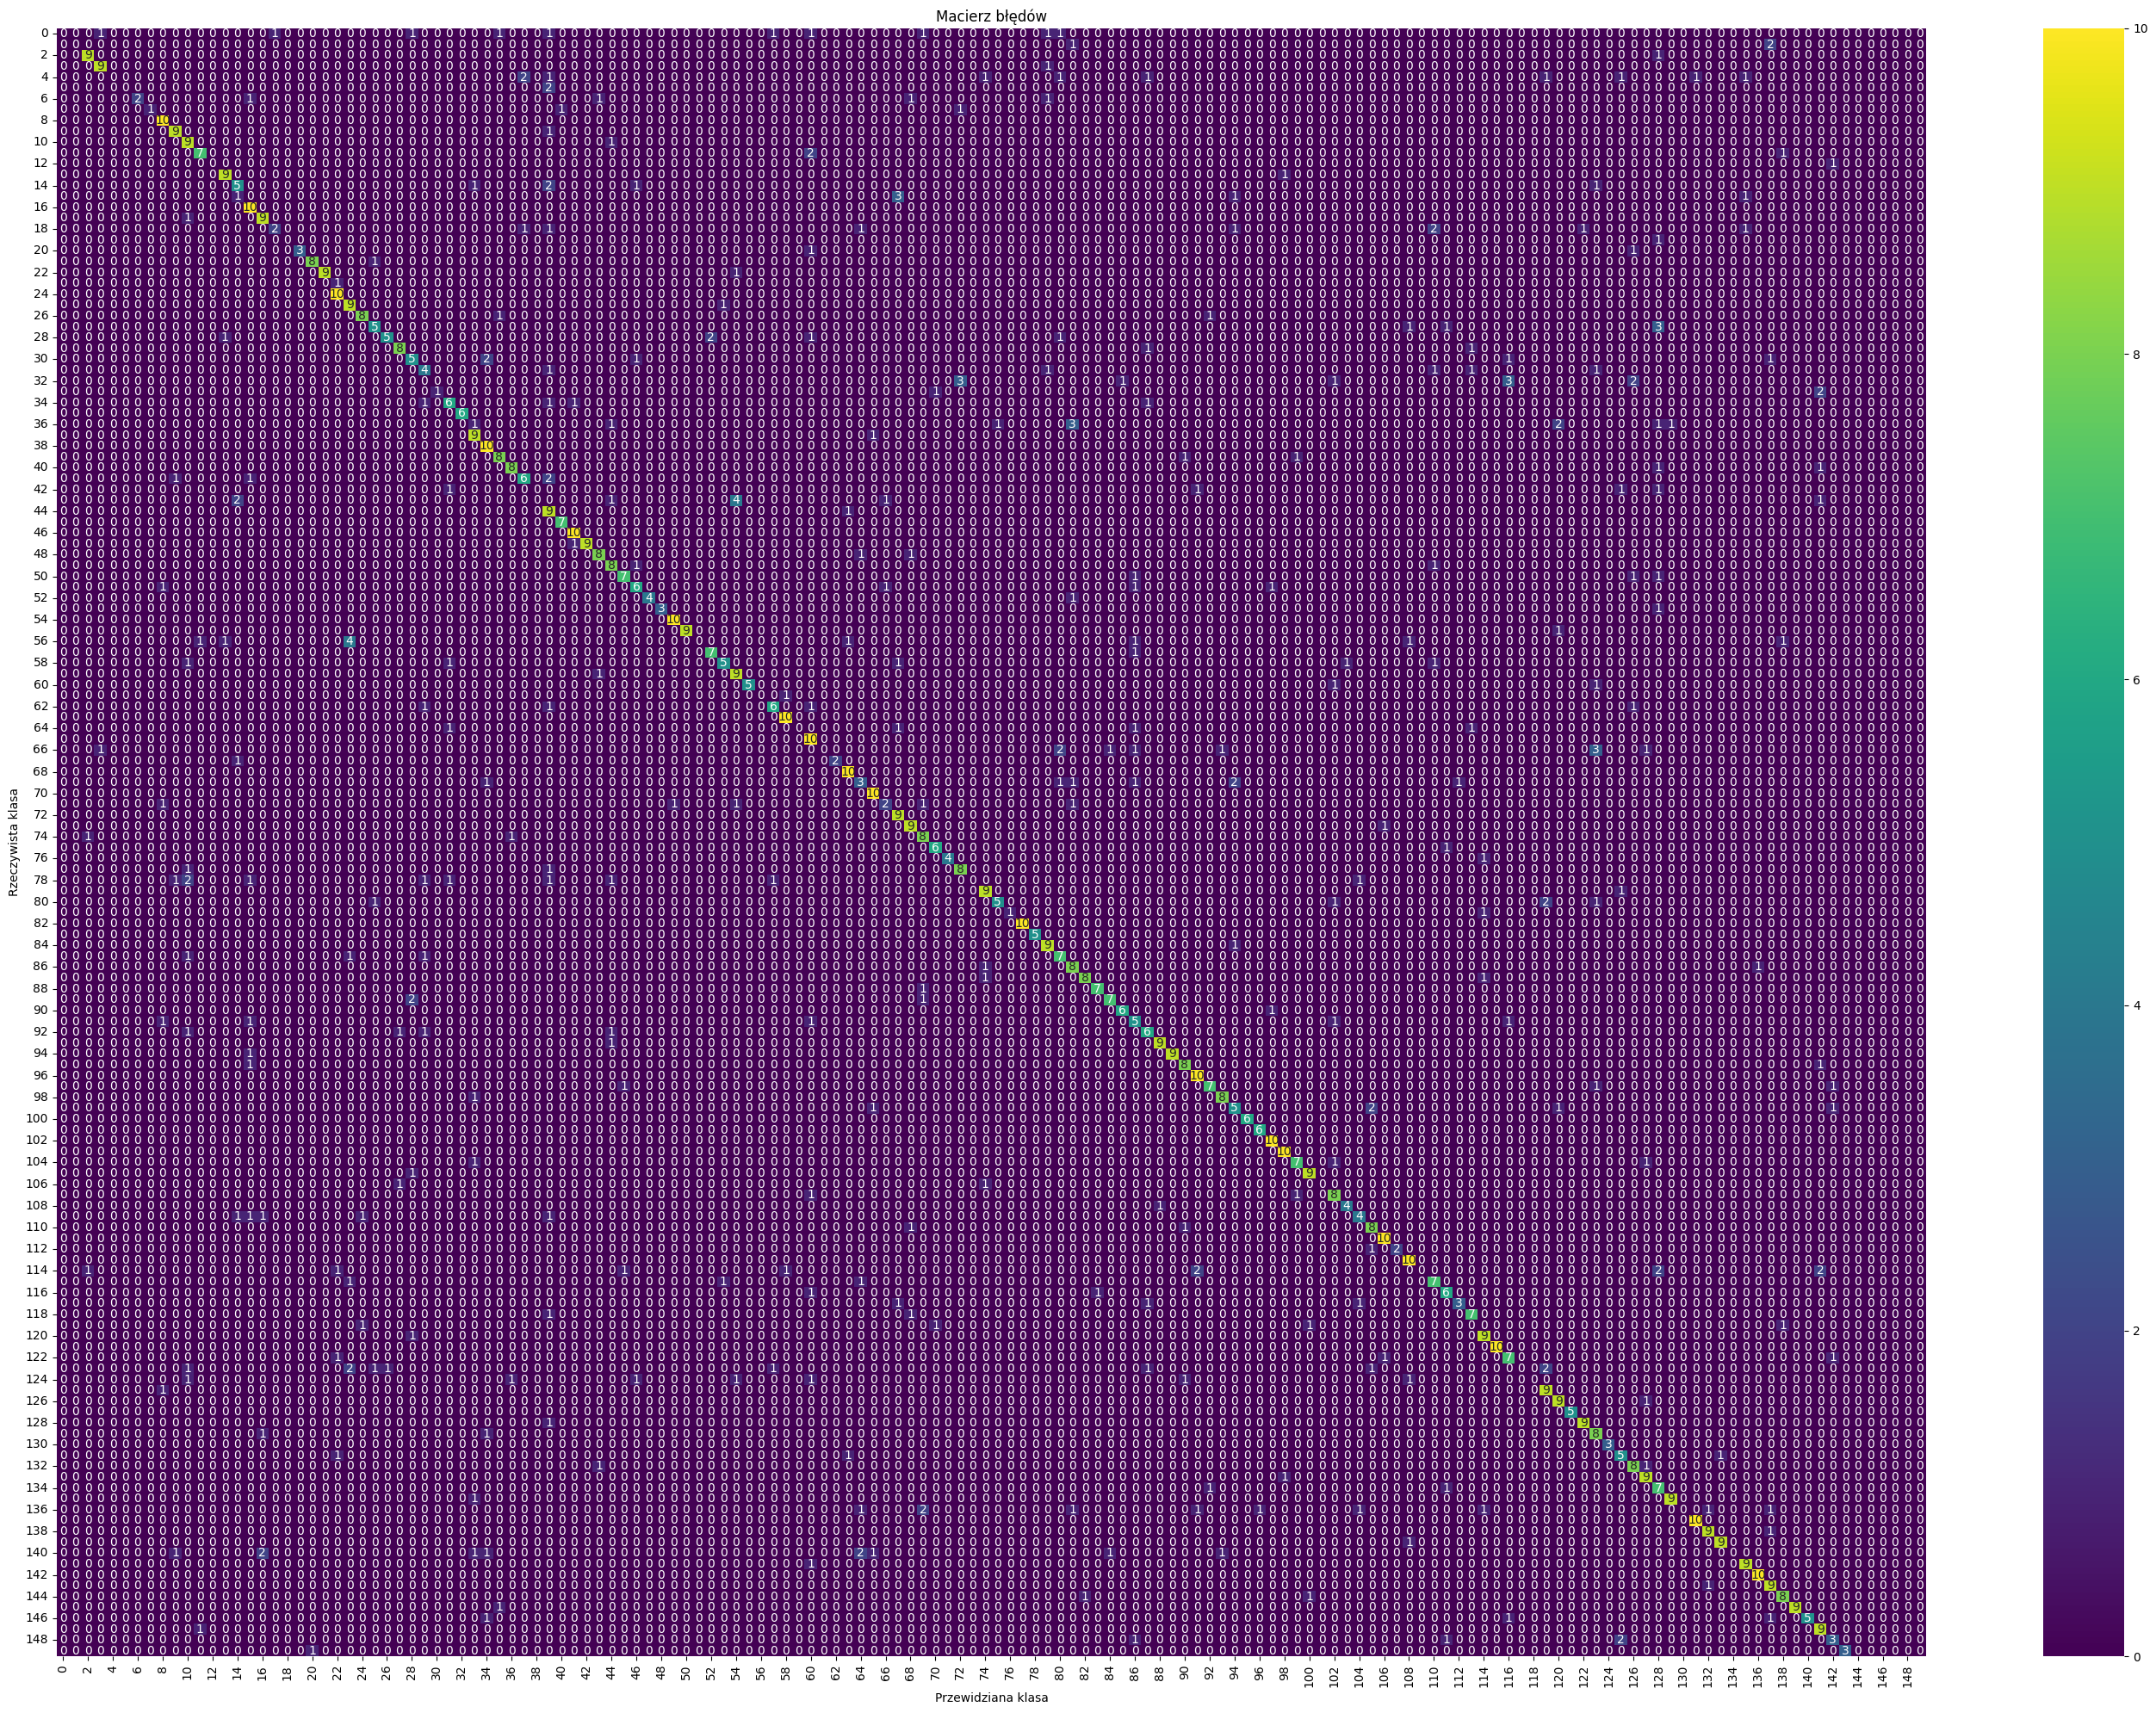

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Stworzenie heatmapy
cm = confusion_matrix(all_labels, all_preds)

print("Macierz błędów:")

plt.figure(figsize=(28, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", cbar=True)
plt.title("Macierz błędów")
plt.xlabel("Przewidziana klasa")
plt.ylabel("Rzeczywista klasa")
plt.tight_layout()
plt.show()

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    accuracy_score, recall_score, f1_score,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize


# Zamień listy na NumPy
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)  # Prawdopodobieństwa (output softmax)

# Zakładamy, że klasy są 0, 1, ..., n_classes-1
n_classes = all_probs.shape[1]

# One-hot / binarize ground truth
all_labels_bin = label_binarize(all_labels, classes=list(range(n_classes)))

# Top-5 prediction indices

top5_preds = np.argsort(all_probs, axis=1)[:, -5:]  # Najwyższe 5 wartości (indeksy)

# Sprawdzenie, czy prawdziwa etykieta jest w top-5
matches = [label in top5 for label, top5 in zip(all_labels, top5_preds)]

# Obliczenie Top-5 Accuracy
top5_accuracy = np.mean(matches) * 100  # w procentach


# ======= METRYKI OGÓLNE =======
print("=== Statystyki ogólne ===")
print("Accuracy:", accuracy_score(all_labels, all_preds)*100)
print("Recall (macro):", recall_score(all_labels, all_preds, average='macro')*100)
print("F1 Score (macro):", f1_score(all_labels, all_preds, average='macro')*100)
print("Top-5 Accuracy:", top5_accuracy)
'''
# ======= ROC + AUC ======= # ======= PR CURVE =======
fpr = dict()
tpr = dict()
roc_auc = dict()

precision = dict()
recall_vals = dict()

for i in range(n_classes):
    if np.sum(all_labels_bin[:, i]) == 0 or np.sum(all_labels_bin[:, i]) == all_labels_bin.shape[0]:
        print(f"⚠️ Pomijam klasę {i} – brak zróżnicowania (same 0 lub same 1).")
        continue
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall_vals[i], _ = precision_recall_curve(all_labels_bin[:, i], all_probs[:, i])

# ======= PLOT =======
plt.figure()

# ROC

for i in range(len(roc_auc)):
  plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Precision-Recall
plt.figure()
for i in range(len(precision)):
  plt.plot(recall_vals[i], precision[i], label=f'Class {i}')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()
'''


=== Statystyki ogólne ===
Accuracy: 5.4858934169279
Recall (macro): 4.911111111111111
F1 Score (macro): 4.735095314042683
Top-5 Accuracy: 8.77742946708464


'\n# ======= ROC + AUC ======= # ======= PR CURVE =======\nfpr = dict()\ntpr = dict()\nroc_auc = dict()\n\nprecision = dict()\nrecall_vals = dict()\n\nfor i in range(n_classes):\n    if np.sum(all_labels_bin[:, i]) == 0 or np.sum(all_labels_bin[:, i]) == all_labels_bin.shape[0]:\n        print(f"⚠️ Pomijam klasę {i} – brak zróżnicowania (same 0 lub same 1).")\n        continue\n    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])\n    roc_auc[i] = auc(fpr[i], tpr[i])\n\n    precision[i], recall_vals[i], _ = precision_recall_curve(all_labels_bin[:, i], all_probs[:, i])\n\n# ======= PLOT =======\nplt.figure()\n\n# ROC\n\nfor i in range(len(roc_auc)):\n  plt.plot(fpr[i], tpr[i], label=f\'Class {i} (AUC = {roc_auc[i]:.2f})\')\nplt.plot([0, 1], [0, 1], \'k--\')\nplt.title(\'ROC Curve (One-vs-Rest)\')\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.legend()\n\n# Precision-Recall\nplt.figure()\nfor i in range(len(precision)):\n  plt.plot(recal